### General imports

In [1]:
import datetime
import glob
import json
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Local imports and file paths

It is very annoying to have to change the local file paths to suit one's personal computer everytime code is passsed back and forth. Additionally, it can cause unnessisary bugs if not all paths are correctly changed and also, from a security point of view it is bad practice to post personal paths in public spaces like github.

Instead, it is better to have a seperate file that save specific local paths. This file has a structure like a python dictionary data strtucture where a "key" string is used to access the "value" assosiated with that "key." This means shared code can refer to just the key, which is standard, and each user will have a different assosiated "value" which is specific to their personal computer. (If this is unclear see cells below for example of this actually being used.) The same .json file can also be refered to in multiple notebooks so is also convient in that way.

The .json data format is one good way of storing this local information. .json files can be easily read and edited with simple text editors and are also able to be read by python as dictionaries. 

Here is an example of the contents of a .json file with a made up computer home folder path /home/user1 (see local_paths.json in this folder for the actual demo file):

```
{"root_data_folder": "/home/user1/nest_photos",
 "frame_positions_file": "/home/user1/3D_nest_2021/img_to_text_df_TOEDIT.csv",
 "nest_data_entry": "/home/user1/3D_nest_2021/3D_HB_nest_data_entry.csv",
 "local_functions": "/home/user1/colony3d/functions"
}
```

In [2]:
# Load local_paths.json (This is the only local path that must be changed)
with open("/home/golden/bee-colony-growth/local_paths.json") as f:
    local_paths = json.load(f)

# Tell notebook where local functins are saved
import sys
sys.path.append(local_paths['local_functions'])

# Load local functions that are used in this notebook
import contents_processing as cp

In [3]:
# Location of the box folder .../3D_nest_2021/nest_photos
root_data_folder = local_paths['root_data_folder']
# Read in img_to_text_df_TOEDIT.csv as pandas dataframe
all_frame_positions = pd.read_csv(local_paths['frame_positions_file'])
# Convert the data in the date colum from numeric type to string
all_frame_positions['date'] = all_frame_positions['date'].astype("string")
# Read 3D_HB_nest_data_entry.csv as a pandas dataframe
data_entry = pd.read_csv(local_paths['nest_data_entry'])

In [4]:
colony_name = "DD5"
data_type = "comb_type_predictions" # can be "comb_type_predictions" or "content_predictions"

if data_type == "comb_type_predictions":
    # A list of the possible comb types
    class_names = cp.get_comb_types()
elif data_type == "content_predictions":
    # A list of the possible comb types
    class_names = cp.get_content_types()

Using colony: DD5


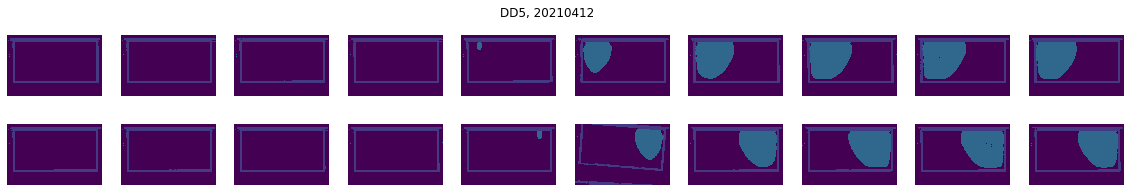

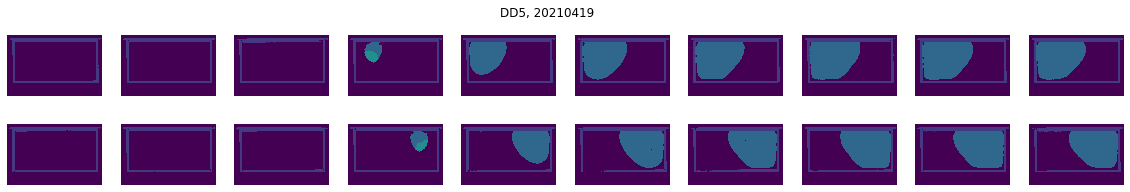

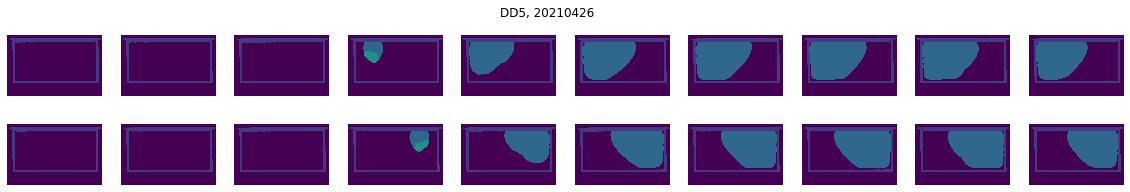

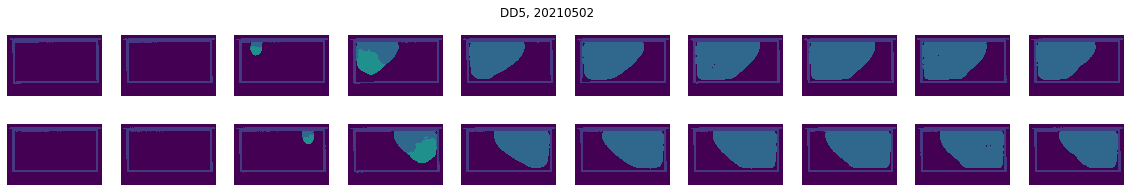

In [6]:
print(f"Using colony: {colony_name}")

colony_folder = os.path.join(root_data_folder, colony_name)
# dates for given colony
dates = cp.get_dates(colony_folder)
# only look at first 4 weeks
dates = dates[:4]

# get just frame position information for specific colony
colony_rows = all_frame_positions['colony'] == colony_name
colony_frame_positions = all_frame_positions[colony_rows]

# The arrays recording either the contents or type of comb in frames (with downsampling)
colony = cp.load_colony(colony_folder, data_type, dates, 
                        colony_frame_positions, downsample=4)

for ind, (date, labels) in enumerate(colony.items()):
    cp.show_colony(labels, len(class_names), f"{colony_name}, {date}")

### Quantify stats for single frame and whole week

size of the array for a single week: (20, 800, 1240)
colony DD5 at week 20210502 has the following quantities of class types...
background: 13234095
wood: 2358333
worker: 4060712
drone: 186860
queen: 0
bee: 0
colony DD5 at week 20210502 at frameside position 7 has the following quantities of class types...
background: 695567
wood: 116115
worker: 100835
drone: 79483
queen: 0
bee: 0


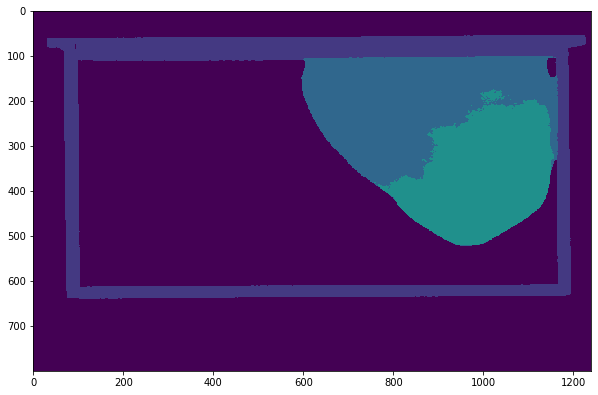

In [8]:
date = dates[3] # Look at data from SECOND week (starts countting at 0)

week_data = colony[date] # this is a 3D array (frame sides x height x width)
print(f"size of the array for a single week: {week_data.shape}")

# Count how much of each pixel class is present in the colony this week
class_counts = np.bincount(np.ravel(week_data), minlength=len(class_names))

print(f"colony {colony_name} at week {date} has the following quantities of class types...")
for class_name, class_count in zip(class_names, class_counts):
    print(f"{class_name}: {class_count}")
    
# look just at the comb in frame 4 side a
frameside = 7 # corresponds to frame 4 side a (1 is frame 1 side a, 2 is frame 1b etc.)

# Count how much of each pixel class is present in the colony this week
class_counts = np.bincount(np.ravel(week_data[frameside]), 
                           minlength=len(class_names))

print(f"colony {colony_name} at week {date} at frameside position {frameside}",
      "has the following quantities of class types...")
for class_name, class_count in zip(class_names, class_counts):
    print(f"{class_name}: {class_count}")
    
plt.figure(figsize=(10,10))
plt.imshow(week_data[frameside], vmin=0, vmax=len(class_names),
          interpolation="nearest")

### Compare two colonies

In [9]:
colony_names = ["DD1", "DD5"]

# only look at first 10 weeks
max_week = 10

all_colonies = []
for colony_name in colony_names:
    print(f"Processing colony: {colony_name}")

    colony_folder = os.path.join(root_data_folder, colony_name)
    dates = cp.get_dates(colony_folder)
    dates = dates[:max_week]

    colony_rows = all_frame_positions['colony'] == colony_name
    colony_frame_positions = all_frame_positions[colony_rows]

    colony = cp.load_colony(colony_folder, data_type, dates, 
                         colony_frame_positions, downsample=4)

    # get counts of each class in each frame and store in dataframe
    colony_class_counts = cp.create_class_count_df(colony, class_names)
    # Add columns saving colony name and experiment type
    colony_class_counts['colony_name'] = colony_name
    colony_class_counts['experiment_type'] = colony_name[:2]
    
    all_colonies.append(colony_class_counts)
# Create one large data frame with info from both colonies
all_colonies = pd.concat(all_colonies)

Processing colony: DD1
Processing colony: DD5


In [10]:
# Add a column for the day since experiment
dates = all_colonies['date']
dates = [str(d) for d in dates]
dates = [datetime.date(int(d[:4]), int(d[4:6]), int(d[6:])) for d in dates]
first_date = sorted(dates)[0]
days = [(d - first_date).days for d in dates]

all_colonies['day'] = days

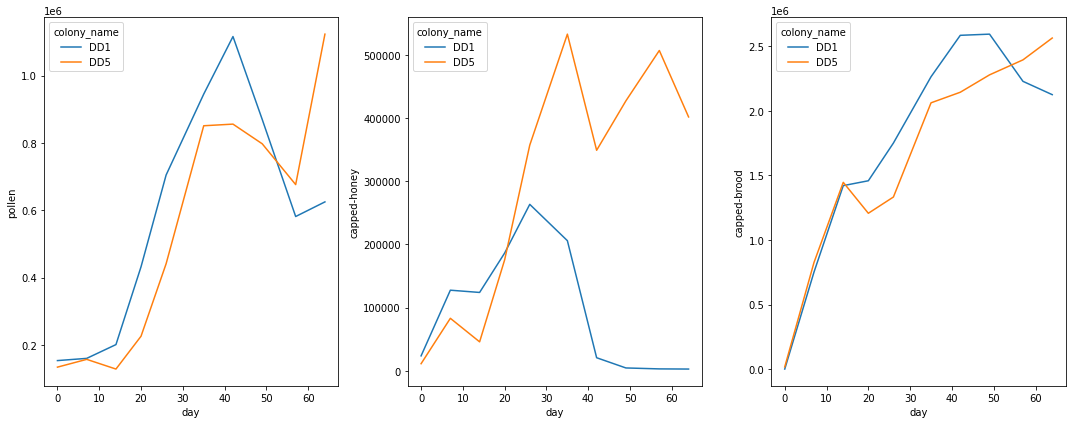

In [42]:
# Demo plot if using content_predictions

if data_type == "comb_type_predictions":
    print("set data_type to 'content_predictions' to build this graph")

fig, axs = plt.subplots(1, 3, figsize=(15, 6))

cmap = matplotlib.cm.get_cmap('tab10')

sns.lineplot(ax=axs[0], data=all_colonies, x="day", y="pollen", hue="colony_name")
sns.lineplot(ax=axs[1], data=all_colonies, x="day", y="capped-honey", hue="colony_name")
sns.lineplot(ax=axs[2], data=all_colonies, x="day", y="capped-brood", hue="colony_name")

plt.tight_layout()

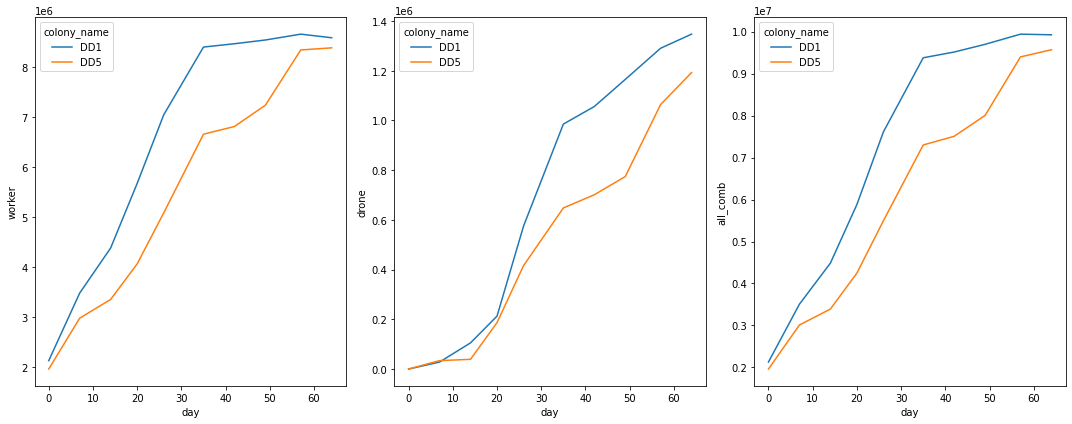

In [13]:
# Demo plot if using comb_type_predictions

# Add a column that quantifies total comb (both worker and drone)
all_colonies["all_comb"] = all_colonies["worker"] + all_colonies["drone"]

fig, axs = plt.subplots(1, 3, figsize=(15, 6))

cmap = matplotlib.cm.get_cmap('tab10')

sns.lineplot(ax=axs[0], data=all_colonies, x="day", y="worker", hue="colony_name")
sns.lineplot(ax=axs[1], data=all_colonies, x="day", y="drone", hue="colony_name")
sns.lineplot(ax=axs[2], data=all_colonies, x="day", y="all_comb", hue="colony_name")

plt.tight_layout()